# This notebook calculates the histograms used in 'Standing on Apollo’s Shoulders: a Microseismometer for the Moon'

Section 1 - Code

Section 2 - Accepted events with signal-to-noise ratio of more than 2.5 - S12 (makes figure cumulative_count_S12.pdf) 

Section 3 - Histogram for the full Nakamura catalog

Section 4 - Nakamura catalog, using the catalog amplitudes

In [1]:
# The following temp directories contain npz files from pre-calculated power spectral densities (ppsd)
# The temp directories must be already populated. 
# tmp_Nakamura_npz
# tmp_npz
# To re-calculate the ppsd's (or to see how they were calculated)  use make_and_check_catalogs.ipynb 


# The catalogs in this temp directory are shortened versions of the Nakmura catalog. 
# This is for faster calculations of the plots in this notebook. 
# tmp_catalogs


# To calculate the histograms, we first calculate power spectral densities. We then 
# find the magnitude at 0.45 Hz. We then make cummulative plots of the histograms. 

# Shallow moonquakes are calculated for all years, and then scaled by 1/7 for the approximate number
# of years of operation. 

# The other moonquake categories (deep and meteroid impacts) are calculated for the year 1973.

# Section 1 - Code

In [2]:

%pylab inline
# from scipy import interpolate, signal
# import time 
from obspy.core import read, Stream
from obspy.core.event import Catalog
import numpy as np
import matplotlib.pylab as plt
import os
import glob
from obspy.core.utcdatetime import UTCDateTime
# import urllib.request
from obspy import read_events, read_inventory
from obspy.signal import PPSD
# from obspy.io.jaxa_moon.core import _read_jaxa_moon
from statistics import mode

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 4
plt.rcParams['lines.linewidth'] = 0.5
plt.rcParams['font.size'] = 12
SECONDS_PER_DAY=3600.*24


Populating the interactive namespace from numpy and matplotlib


In [3]:
# top_level_processed_dir = '/Users/cnunn/lunar_data/PDART_PROCESSED'
top_level_processed_dir = None
inv_name = "/Users/cnunn/lunar_data/Dataless_SEED/XA.1969-1977_updated_2019.xml"
top_level_dir_GEOSCOPE = '/Users/cnunn/lunar_data/GEOSCOPE_lunar_data'

In [4]:
# nicely formated tick marks
import matplotlib.ticker as mticker
class MathTextSciFormatter(mticker.Formatter):
    def __init__(self, fmt="%1.2e"):
        self.fmt = fmt
    def __call__(self, x, pos=None):
        s = self.fmt % x
        decimal_point = '.'
        positive_sign = '+'
        tup = s.split('e')
        significand = tup[0].rstrip(decimal_point)
        sign = tup[1][0].replace(positive_sign, '')
        exponent = tup[1][1:].lstrip('0')
        if exponent:
            exponent = '10^{%s%s}' % (sign, exponent)
        if significand and exponent:
            s =  r'%s{\times}%s' % (significand, exponent)
        else:
            s =  r'%s%s' % (significand, exponent)
        return "${}$".format(s)

In [5]:
# histogram preparation
def histogram_preparation(catalogs,top_level_dir,dir_type,inv_name,
  xaxis_frequency=True,show_noise_models=True, station_code='S12',
  min1=3e-10,max1=2e-08,title=None,figname=None):
    
#         3.75837404288e-10
# 1.49623565609e-08
    num = 11
    # 2.17520403402e-10
    # 8.17523037944e-09
    ampl_total = []
    bins_center_list = []
    bins_list = []
    n_list = []
    
    for (catalog, color, label, scaling, folder) in catalogs:
        count = 0
        ampl = []
        catalog_basename = os.path.basename(catalog).replace('.xml','')
        filename_pattern = '{}_smi_*.npz'.format(catalog_basename)

        matches = glob.glob(os.path.join(folder,filename_pattern))
        
        for filename in matches:
            ppsd = PPSD.load_npz(filename)
            
            count +=1
            
            try:
                # There's only one segment, so it's not a mode)              
                (seismogram_pbc, seismogram_mode) = ppsd.get_mode()
            except Exception as e: 
                print(filename)
                print(e)
                print('continuing')
                
                
            # find the index of the first period over 2.2 s          
            i_2 = np.min(np.argwhere(seismogram_pbc > 2.2))

            if xaxis_frequency:
                xdata = 1.0 / seismogram_pbc
            else:
                xdata = seismogram_pbc
                
            # go to physical units from dB
            ydata = 10**(seismogram_mode/20.)
            
            ampl.append(ydata[i_2])

        # add to the total list          
        ampl_total.extend(ampl)
            
        print('Successful count (', catalog_basename, ')', count) 
        fig, ax = plt.subplots(figsize=(8, 4))
        # plot the cumulative histogram
#         count, bins  = np.histogram(ampl, 10, normed=True)
        n, bins, patches = ax.hist(ampl, bins=np.logspace(np.log10(min1), np.log10(max1), num=num), histtype='step', 
#                                    normed=False, 
                                   cumulative=-1, label=label, color=color)
        plt.gca().set_xscale("log")
        xlim = ax.get_xlim()
        plt.legend()
        plt.show()

        # this would plot the log of the cumulative total (good for Gutenberg Richter)        
#         plt.scatter(center,np.log10(n),label=label)
        bin_center = [((bins[i+1]-bins[i])/2)+bins[i] for (i, c) in enumerate(bins[0:-1])]
        bins_center_list.append(bin_center)
        bins_list.append(bins)
        
        # include the scaling 
        n = n.tolist()
        n = [n1*scaling for n1 in n]
        n_list.append(n)

    print(min(ampl_total))
    print(max(ampl_total))
    


    if min1 > min(ampl_total):
        print('Bin min is too large')
    if max1 < max(ampl_total):
        print('Bin max is too small')
    
    
    #     
    fig, ax = plt.subplots(figsize=(8, 4))
    # calculate the total  
    n, bins, patches = ax.hist(ampl_total, bins=np.logspace(np.log10(min1), np.log10(max1), num=num), 
                               histtype='step',
                               density=True,
#                                normed=False, 
                               cumulative=-1, label='All',color='k')
    plt.gca().set_xscale("log")
    xlim = ax.get_xlim()
    plt.legend()
    plt.title('Combined histogram (WITHOUT SCALING)')
    plt.show()
    
    fig, ax = plt.subplots(figsize=(16, 4))
#     bin_center = [((bins[i+1]-bins[i])/2)+bins[i] for (i, c) in enumerate(bins[0:-1])]
#     plt.plot(bin_center,n,color='k')
#     plt.scatter(bin_center,n,label='All',color='k')
    
    n_total =  [0] * len(n_list[0])
    for i, (_, color, label, scaling, _) in enumerate(catalogs):
        n_total = [a + b for a, b in zip(n_total, n_list[i])] 

    plt.scatter(bins_center_list[0],n_total,color='k',label='Total')
    plt.plot(bins_center_list[0],n_total, color='k')    
    
    for i, (_, color, label, scaling, _) in enumerate(catalogs): 
        # plot values (include the scaling)         
        plt.scatter(bins_center_list[i],n_list[i],color=color,label=label)
        plt.plot(bins_center_list[i],n_list[i], linestyle='solid', color=color)

    plt.gca().set_xscale("log")
    ax.set_xlim(xlim)
    plt.legend()
    plt.show() 
    
    # 6.9*(365/15)=167.9
#     conversion_factor=167.9
#     # one lunar day (while there's sunlight - roughly 2 earth weeks)
#     n_day_deep = [i/conversion_factor for i in n_deep]
#     n_day_meteorite = [i/conversion_factor for i in n_meteorite]
#     n_day_shallow = [i/conversion_factor for i in n_shallow]


    # plot histogram 

    fig, ax1 = plt.subplots(figsize=(8, 4))

    bottom =  [0] * len(n_list[0])

    for i, (_, color, label, scaling, _) in enumerate(catalogs): 
        width = [(bins_list[i][j+1] - bins_list[i][j]) for j, _ in enumerate(bins_list[i][:-1])] 
        p = plt.bar(bins_center_list[i], n_list[i], width=width, bottom=bottom,
                    align='center',alpha=0.4, color=color,label=label)
        accumulated_total = n_list[i][0]+bottom[0] 

        bottom = [(bottom[j] + n_list[i][j]) for j, _ in enumerate(bottom)]

    xmin = bins_list[0][0]
    xmax = bins_list[0][-1]
    
    print('Total:', accumulated_total)
    
 

    if title is None:
        title = 'Cumulative Count of Lunar Events at {}'.format(station_code)
    plt.title(title)
    ax1.set_ylabel('Cumulative count per year')
    plt.xlabel(r'Amplitude [$(m/s^2)/\sqrt{Hz}$ at 0.45 Hz]')
    plt.gca().set_xscale("log")
    ax1.set_xlim(xmin,xmax)
    ylim1, ylim2 = ax1.get_ylim()

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylim(0, ylim2/26)  
    ax2.grid(False)  
    ax2.set_ylabel('Cumulative count per lunar day\n(approx. 2 Earth weeks)',color='#002078')
    ax2.tick_params(axis='y', labelcolor='#002078')  

    # plot the ticks nicely
    locs = [xmin, 1e-9, xmax]
    xticks(locs, locs)
    plt.gca().xaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    ax1.tick_params(which='minor', length=4)

    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(reversed(handles), reversed(labels))
    plt.tight_layout()
    if figname is None:
        figname = 'plots/cumulative_count_{}.pdf'.format(station_code)
    plt.savefig(figname)
    plt.show()


    
    return bins_center_list, n_total, n_list, xlim, bins_list, ampl_total
    

In [6]:
# Signal envelope amplitudes in mm measured on a standard
#               compressed-scale plot.  Z component is used for stations
#               11 and 12, and Y component is used for all the other
#               stations.  Standard compressed plot is produced by first
#               taking the absolute value of the difference between
#               consecutive long-period data points, summing them over
#               40 data points (approx. 6 s), and then plotting them at a
#               scale of 157 digital units/cm in alternating polarities
#               to give the appearance of a seismogram.  Four columns are
#               assigned to each of Apollo stations 12 (or 11), 14, 15
#               and 16.


# # repeat for the full Nakamura catalog - with the arbitrary amplitude 
# histogram preparation
def histogram_preparation_Nakamura(catalogs,top_level_dir,dir_type,inv_name,
  xaxis_frequency=True,show_noise_models=True, station_code='S12'):
    
    nak_bins_center_list = []
    nak_bins_list = []
    nak_n_list = []
    
    for (catalog, color, label, scaling) in catalogs:
        count = 0

        fig, ax = plt.subplots(figsize=(8, 4))
        
        cat = read_events(catalog)
        
        amplitudes_station = []
        
        for ev in cat: 
            picks = ev.picks

            amplitudes = ev.amplitudes 

            for p in picks:        
                if p.waveform_id.station_code == station_code:
                    for a in ev.amplitudes:
                        if a.pick_id == p.resource_id:
                            if a.generic_amplitude > 0:
                                amplitudes_station.append(a.generic_amplitude)
                                count+=1                    
                                
        print('Successful count (', label, ')', count) 
        print(amplitudes_station)

        n, bins, patches = ax.hist(amplitudes_station, bins=range(0,71), histtype='step', 
#                                    normed=False, 
                                   cumulative=-1, label=label, color=color)
            
        xlim = ax.get_xlim()
        plt.legend()
        plt.show()

        nak_bin_center = [((bins[i+1]-bins[i])/2)+bins[i] for (i, c) in enumerate(bins[0:-1])]
        nak_bins_center_list.append(nak_bin_center)
        nak_bins_list.append(bins)
        
        # include the scaling 
        n = n.tolist()
        n = [n1*scaling for n1 in n]
        nak_n_list.append(n) 
        
        
    # plot histogram 
    fig, ax1 = plt.subplots(figsize=(8, 4))

    bottom =  [0] * len(nak_n_list[0])

    for i, (_, color, label, scaling) in enumerate(catalogs): 
        width = [(nak_bins_list[i][j+1] - nak_bins_list[i][j]) for j, _ in enumerate(nak_bins_list[i][:-1])] 
        p = plt.bar(nak_bins_center_list[i], nak_n_list[i], width=width, bottom=bottom,
                    align='center',alpha=0.4, color=color,label=label)
        
        accumulated_total = nak_n_list[i][0]+bottom[0] 

        bottom = [(bottom[j] + nak_n_list[i][j]) for j, _ in enumerate(bottom)]
    
    print('Total:', accumulated_total)
    

    xmin = nak_bins_list[0][0]
    xmax = nak_bins_list[0][-1]
    plt.title('Cumulative Count of Lunar Events at S12\nNakamura Catalog')
    ax1.set_ylabel('Cumulative count per year')
    ax1.set_xlim(xmin,xmax)
    ylim1, ylim2 = ax1.get_ylim()

    plt.xlabel('Signal Amplitude\n(see figure caption for definition)')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylim(0, ylim2/26)  
    ax2.grid(False)  
    ax2.set_ylabel('Cumulative count per lunar day\n(approx. 2 Earth weeks)',color='#002078')
    ax2.tick_params(axis='y', labelcolor='#002078')

    ax1.set_xlim(0,25)

    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(reversed(handles), reversed(labels))
    plt.tight_layout()
    plt.savefig('plots/cumulative_count_Nakamura_catalog.pdf')

    plt.show()

    
    return nak_bins_center_list, nak_n_list, xlim, nak_bins_list
              


# Section 2 - Accepted events with signal-to-noise ratio of more than 2.5 - S12

Successful count ( S12_shallow ) 7


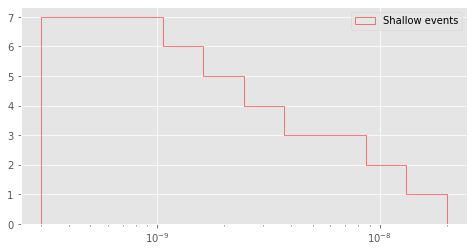

Successful count ( 1973_S12_met ) 24


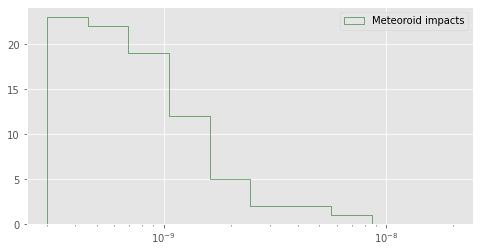

Successful count ( 1973_S12_deep ) 51


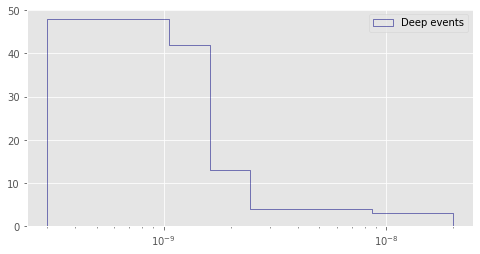

3.75837404288e-10
2.98538261892e-08
Bin max is too small


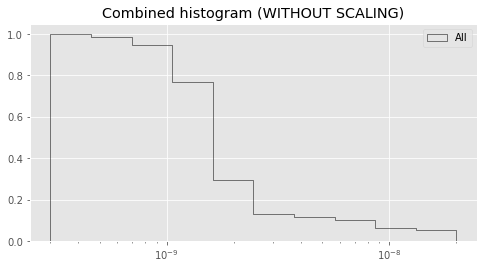

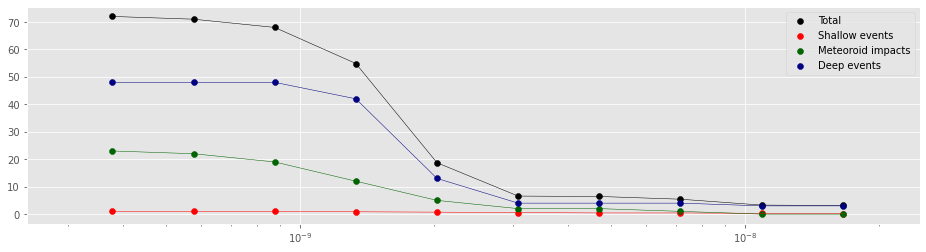

Total: 72.0


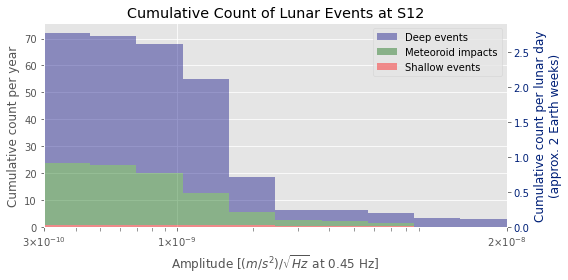

In [7]:
# Cummulative plots of selected events with signal-to-noise ratio of approx 2.5 or greater
# This requires the .npz files to be correct in the temp folder tmp_npz
# If there are problems, run the files in make_and_check_catalogs.ipynb
catalogs = [
  ['tmp_catalogs/S12_shallow.xml', 'red', 'Shallow events',1/7,'tmp_npz'],
  ['tmp_catalogs/1973_S12_met.xml', 'darkgreen', 'Meteoroid impacts',1,'tmp_npz'],
  ['tmp_catalogs/1973_S12_deep.xml', 'navy', 'Deep events',1,'tmp_npz']
  ]
# spectra in root Hertz????
bins_center_list, n_total, n_list, xlim, bins_list, ampl_total  = histogram_preparation(catalogs,
    top_level_processed_dir,dir_type='processed_dir',
    inv_name=inv_name,
    xaxis_frequency=True,show_noise_models=False,station_code='S12')

# CHECKED

# Section 3 - Histogram for the full Nakamura catalog 
All events in the catalog are accepted

S12 - Full Nakamura catalog 

Successful count ( S12_shallow ) 23


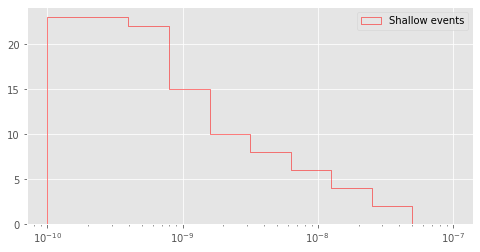

Successful count ( 1973_S12_met ) 135


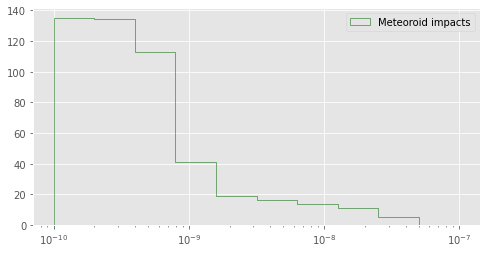

tmp_Nakamura_npz/1973_S12_deep_smi_nakamura81_event_06152.npz
No data accumulated
continuing
Successful count ( 1973_S12_deep ) 469


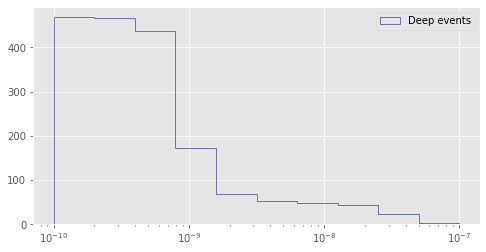

1.05925372518e-10
9.44060876286e-08


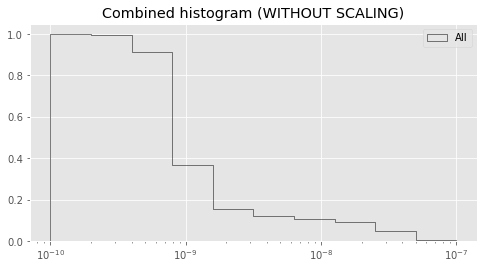

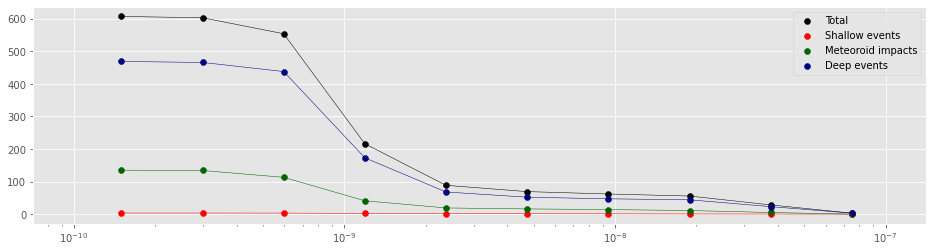

Total: 607.2857142857142


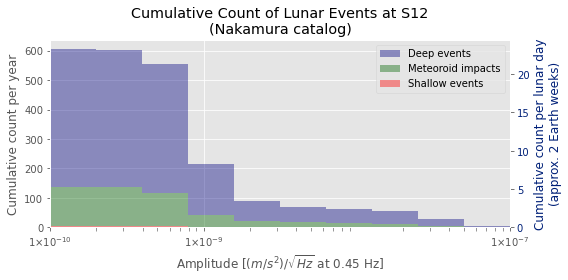

In [8]:
# Cummulative plots of selected events with signal-to-noise ratio from Nakamura catalog
# If there was no Z component, or nothing in the response file at the time, this code ignores the event
# This requires the .npz files to be correct in the temp folder tmp_Nakamura_npz
# If there are problems, run the files in make_and_check_catalogs.ipynb

catalogs = [
  ['tmp_catalogs/S12_shallow.xml', 'red', 'Shallow events',1/7,'tmp_Nakamura_npz'],
  ['tmp_catalogs/1973_S12_met.xml', 'darkgreen', 'Meteoroid impacts',1,'tmp_Nakamura_npz'],
  ['tmp_catalogs/1973_S12_deep.xml', 'navy', 'Deep events',1,'tmp_Nakamura_npz'],
  ]

bins_center_list, n_total, n_list, xlim, bins_list, ampl_total  = histogram_preparation(catalogs,
    top_level_processed_dir,dir_type='processed_dir',
    inv_name=inv_name,
    xaxis_frequency=True,show_noise_models=False,station_code='S12', min1=1e-10,max1=1e-7,
    title='Cumulative Count of Lunar Events at S12\n(Nakamura catalog)',figname='plots/cumulative_count_Nakamura_cat_S12.pdf')

# We found approximately 70 events per year using a signal-to-noise ratio, and just over 800 when 
# using the full catalog (approximately 11 times as many)


# CHECKED

S16 - Full Nakamura Catalog 

Successful count ( S16_shallow ) 23


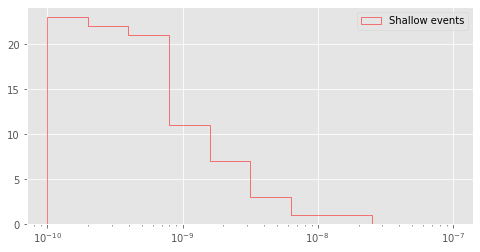

Successful count ( 1973_S16_met ) 145


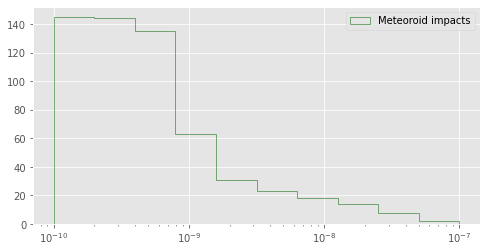

tmp_Nakamura_npz/1973_S16_deep_smi_nakamura81_event_06870.npz
No data accumulated
continuing
Successful count ( 1973_S16_deep ) 667


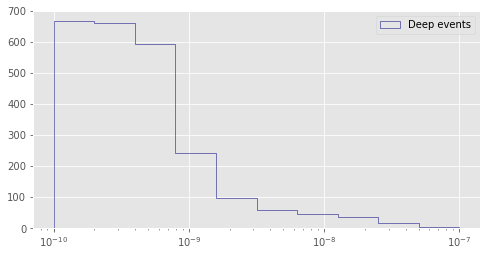

1.33352143216e-10
5.30884444231e-08


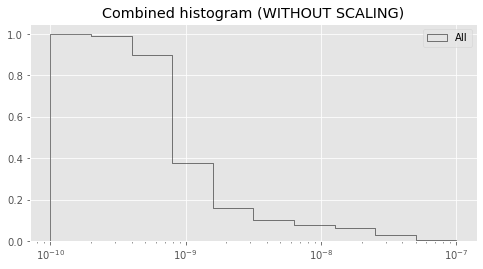

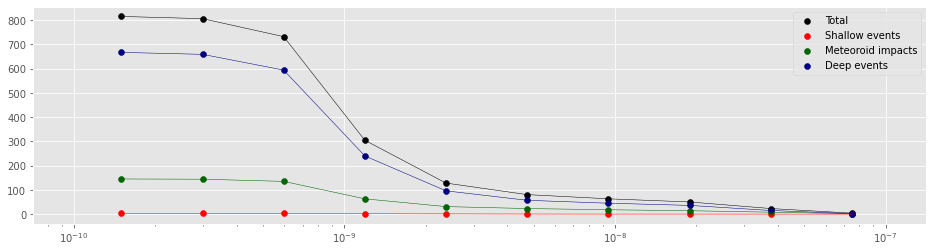

Total: 815.2857142857142


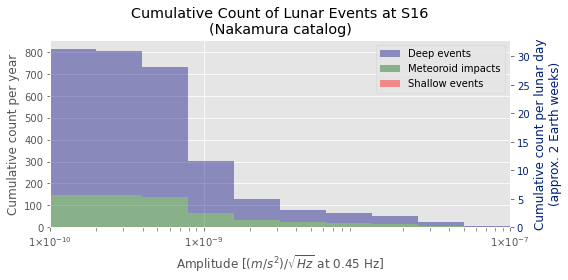

In [9]:
# Cummulative plots of selected events with signal-to-noise ratio from Nakamura catalog
# If there was no Z component, or nothing in the response file at the time, this code ignores the event
# This requires the .npz files to be correct in the temp folder tmp_Nakamura_npz
# If there are problems, run the files in make_and_check_catalogs.ipynb

catalogs = [
  ['tmp_catalogs/S16_shallow.xml', 'red', 'Shallow events',1/7,'tmp_Nakamura_npz'],
  ['tmp_catalogs/1973_S16_met.xml', 'darkgreen', 'Meteoroid impacts',1,'tmp_Nakamura_npz'],
  ['tmp_catalogs/1973_S16_deep.xml', 'navy', 'Deep events',1,'tmp_Nakamura_npz'],
  ]

bins_center_list, n_total, n_list, xlim, bins_list, ampl_total  = histogram_preparation(catalogs,
    top_level_processed_dir,dir_type='processed_dir',
    inv_name=inv_name,
    xaxis_frequency=True,show_noise_models=False,station_code='S16', min1=1e-10,max1=1e-7,
    title='Cumulative Count of Lunar Events at S16\n(Nakamura catalog)',figname='plots/cumulative_count_Nakamura_cat_S16.pdf')


# CHECKED

# Section 4 - Nakamura catalog, using the catalog amplitudes 
S12 

Successful count ( Shallow events ) 19
[26.0, 4.5, 4.5, 2.0, 1.0, 35.0, 17.0, 2.0, 8.0, 70.0, 1.0, 1.0, 2.7, 1.0, 2.0, 1.7, 16.0, 4.0, 1.0]


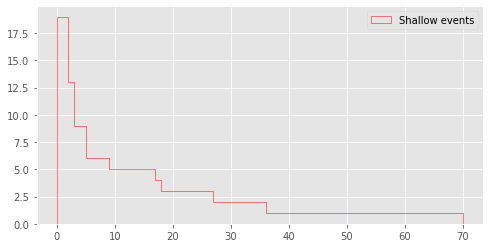

Successful count ( Meteoroid impacts ) 135
[0.5, 1.0, 3.1, 2.1, 1.2, 1.0, 1.2, 3.0, 0.8, 1.1, 0.9, 2.1, 1.5, 1.0, 2.0, 2.0, 3.0, 2.0, 1.5, 1.2, 0.6, 5.0, 1.0, 1.0, 1.5, 2.0, 2.8, 0.8, 1.9, 1.7, 5.0, 6.0, 3.0, 1.0, 20.0, 2.0, 2.0, 1.0, 1.0, 1.1, 10.0, 1.0, 3.0, 1.0, 2.5, 1.0, 1.0, 0.5, 1.0, 1.0, 1.5, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.2, 3.3, 2.0, 1.0, 11.0, 1.0, 5.5, 1.2, 1.2, 1.0, 1.0, 3.0, 1.8, 3.0, 3.0, 4.0, 3.0, 1.0, 0.5, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 18.0, 0.5, 0.5, 3.0, 1.0, 2.0, 5.0, 4.8, 1.5, 1.2, 6.0, 1.0, 0.8, 1.5, 2.8, 1.2, 1.2, 1.7, 1.2, 3.5, 12.0, 1.2, 1.0, 20.0, 0.5, 2.5, 6.0, 2.0, 3.1, 1.0, 0.9, 2.6, 1.4, 3.6, 1.3, 1.6, 1.0, 1.7, 1.2, 1.0, 2.0, 0.9, 2.0, 7.0, 1.2, 2.0, 1.0, 1.0, 2.2, 1.0, 2.0, 4.5, 1.0]


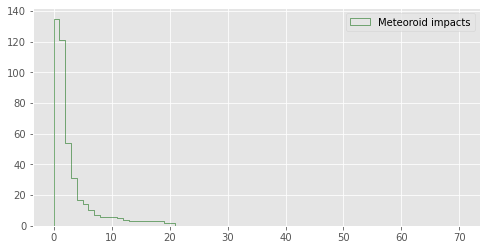

Successful count ( Deep events ) 441
[1.0, 1.8, 0.9, 1.0, 1.0, 1.0, 0.8, 0.8, 0.5, 0.7, 1.0, 0.6, 0.6, 0.8, 1.4, 0.8, 0.9, 1.0, 1.8, 0.9, 0.5, 0.3, 1.0, 0.8, 1.2, 1.0, 2.1, 1.1, 1.1, 0.9, 1.0, 1.8, 2.1, 1.4, 1.0, 1.1, 2.0, 1.1, 2.0, 2.3, 0.8, 1.2, 1.1, 1.7, 1.3, 1.1, 1.0, 1.0, 1.1, 0.9, 1.6, 1.1, 0.7, 1.9, 0.9, 0.9, 1.1, 0.8, 0.6, 1.0, 1.0, 1.5, 1.0, 1.2, 1.2, 1.0, 1.0, 0.7, 2.0, 0.7, 1.0, 2.0, 1.0, 1.0, 1.9, 1.3, 2.2, 1.2, 3.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.8, 0.5, 1.0, 0.5, 0.9, 1.0, 1.0, 0.8, 0.8, 1.8, 0.8, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 0.5, 2.5, 0.5, 0.5, 1.0, 1.2, 1.0, 1.0, 1.0, 1.0, 2.0, 1.8, 0.9, 1.0, 2.5, 0.5, 1.2, 2.0, 1.8, 0.5, 1.0, 0.5, 0.5, 0.5, 0.5, 1.2, 1.2, 1.0, 1.8, 1.5, 1.0, 1.0, 0.5, 2.0, 2.2, 0.5, 1.9, 1.2, 1.3, 0.8, 3.3, 1.0, 1.1, 0.7, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.2, 1.0, 1.0, 2.0, 1.2, 1.0, 1.0, 1.0, 1.0, 0.8, 0.6, 1.2, 0.8, 1.3, 1.0, 0.9, 2.0, 1.0, 0.8, 5.0, 1.0, 1.3, 1.8, 0.8, 0.8, 3.0, 1.0, 1.0, 1.2, 1.0, 0.9, 1.0, 1.0, 1.0, 1.1, 1.0, 1.9, 1.8, 0.

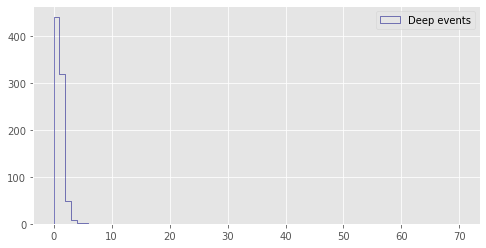

Successful count ( Unclassified events ) 47
[0.7, 1.2, 1.3, 1.2, 1.0, 1.3, 1.2, 1.4, 0.7, 1.1, 1.0, 1.2, 1.0, 1.0, 1.2, 1.0, 1.0, 0.8, 0.5, 1.0, 0.2, 0.3, 0.2, 1.0, 0.8, 0.5, 1.0, 1.0, 2.0, 0.5, 1.0, 1.2, 1.3, 1.5, 1.2, 1.0, 1.0, 1.0, 1.2, 0.8, 1.2, 1.1, 1.0, 1.2, 0.8, 1.0, 1.0]


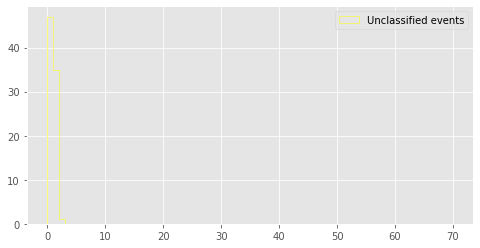

Total: 625.7142857142858


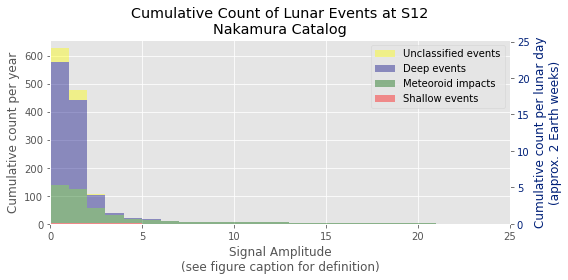

In [10]:
# Histogram using the Nakamura catalog amplitudes
catalogs = [
  ['tmp_catalogs/S12_shallow.xml', 'red', 'Shallow events',1/7],
  ['tmp_catalogs/1973_S12_met.xml', 'darkgreen', 'Meteoroid impacts',1],
  ['tmp_catalogs/1973_S12_deep.xml', 'navy', 'Deep events',1],
  ['tmp_catalogs/1973_S12_unclassified.xml', 'yellow', 'Unclassified events',1]
  ]
# spectra in root Hertz????
nak_bins_center_list, nak_n_list, nak_xlim, nak_bins_list  = histogram_preparation_Nakamura(catalogs,
    top_level_processed_dir,dir_type='processed_dir',
    inv_name=inv_name,
    xaxis_frequency=True,show_noise_models=False,station_code='S12')

# CHECKED

In [11]:
# Nakamura Catlog - S12
# Successful count ( Shallow events ) 19
# Successful count ( Meteoroid impacts ) 135
# Successful count ( Deep events ) 441

In [12]:
print('End of Notebook')

End of Notebook
